# Model: AdaBoost

### Importing Libraries

In [60]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
# Importing the model
from sklearn.ensemble import AdaBoostClassifier
from sklearn.externals import joblib

### Loading in Data

In [6]:
df = pd.read_excel('../top10_corr_features.xlsx')
df = df.drop(df.columns[0], axis = 1)


### Scaling the Data

In [14]:
# StandardScaler: 可保存训练集中的均值、方差参数，然后直接用于转换测试集数据。
scaler = StandardScaler()

features_df = df.drop(["Decision"], 1)

scaled_df = pd.DataFrame(scaler.fit_transform(features_df), 
                               index=features_df.index, 
                               columns=features_df.columns)

df = scaled_df.join(df.Decision)


### Splitting the Data

In [19]:
X = df.drop(["Decision"], 1)
y = df.Decision

# Train, test, split
# random_state 随机数种子：该组随机数的编号，在需要重复试验的时候，保证得到一组一样的随机数。
# 比如每次都填1，其他参数一样的情况下得到的随机数组是一样的。但填0或不填，每次都会不一样。
# train_size: If train_size is None, it will be set to 0.25.
X_train, X_test, y_train, y_test = train_test_split(X, y)


### Helper Functions

#### Function for plotting confusion matrix

In [46]:
def plot_confusion_matrix(y_true, y_pred, labels=["Sell", "Buy", "Hold"], 
                          normalize=False, title=None, cmap=plt.cm.coolwarm):

    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(12,6))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks (刻标)...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=labels, yticklabels=labels,
           title=title,
           ylabel='ACTUAL',
           xlabel='PREDICTED')
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 1.5
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="snow" if cm[i, j] > thresh else "orange",
                    size=26)
    ax.grid(False)
    fig.tight_layout()
    return ax

## Modeling
The preferred evaluation metric used will be __Precision__ for each class.  
They will be optimized using the __F1 Score-Macro-Average__ to balance the Precision and Recall.  
This is done because we want to not only be correct when predicting but also make a decent amount of predictions for each class.  
Classes such as 'Buy' and 'Sell' are more important than 'Hold'.

### Fitting and Training

In [22]:
# Fitting and training
clf = AdaBoostClassifier()
clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None)

### Print out Evaluation Metrics
- micro:  Calculate metrics globally by counting the total true positives, false negatives and false positives.  
        通过先计算总体的TP，FN和FP的数量，再计算F1   
- macro:  Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.  
        分布计算每个类别的F1，然后做平均（各类别F1的权重相同）

In [24]:
# Classifier predictions
pred = clf.predict(X_test)

#Print out results
report = classification_report(y_test, pred, target_names=['Sell', 'Buy', 'Hold'])
print(report)

              precision    recall  f1-score   support

        Sell       0.18      1.00      0.31         2
         Buy       1.00      0.23      0.38        13
        Hold       0.67      1.00      0.80         2

    accuracy                           0.41        17
   macro avg       0.62      0.74      0.49        17
weighted avg       0.86      0.41      0.42        17



### Confusion Matrix

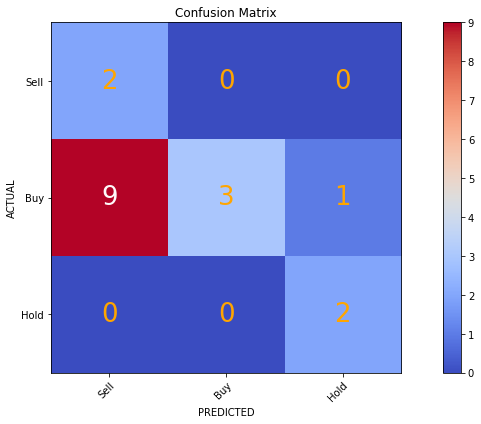

In [57]:
plot_confusion_matrix(y_test, pred, title="Confusion Matrix")
# Plot non-normalized confusion matrix
plt.show()

## Tuning Model Parameters

In [47]:
from sklearn.model_selection import GridSearchCV

### Parameters

In [48]:
# Parameters to Tune
params = {'n_estimators': [50, 100, 200, 500],
          'learning_rate': [1, .1, .01]}

In [49]:
search = GridSearchCV(clf, params, cv=3, return_train_score=True, verbose=5, scoring='f1_macro')

search.fit(X,y)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] learning_rate=1, n_estimators=50 ................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\72445\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s


[CV]  learning_rate=1, n_estimators=50, score=(train=0.874, test=0.286), total=   0.5s
[CV] learning_rate=1, n_estimators=50 ................................
[CV]  learning_rate=1, n_estimators=50, score=(train=0.875, test=0.412), total=   0.1s
[CV] learning_rate=1, n_estimators=50 ................................
[CV]  learning_rate=1, n_estimators=50, score=(train=0.827, test=0.468), total=   0.4s
[CV] learning_rate=1, n_estimators=100 ...............................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.0s remaining:    0.0s


[CV]  learning_rate=1, n_estimators=100, score=(train=0.910, test=0.222), total=   0.2s
[CV] learning_rate=1, n_estimators=100 ...............................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.2s remaining:    0.0s


[CV]  learning_rate=1, n_estimators=100, score=(train=0.841, test=0.401), total=   0.2s
[CV] learning_rate=1, n_estimators=100 ...............................
[CV]  learning_rate=1, n_estimators=100, score=(train=0.879, test=0.363), total=   0.4s
[CV] learning_rate=1, n_estimators=200 ...............................
[CV]  learning_rate=1, n_estimators=200, score=(train=0.946, test=0.360), total=   0.3s
[CV] learning_rate=1, n_estimators=200 ...............................
[CV]  learning_rate=1, n_estimators=200, score=(train=0.928, test=0.350), total=   0.5s
[CV] learning_rate=1, n_estimators=200 ...............................
[CV]  learning_rate=1, n_estimators=200, score=(train=0.879, test=0.420), total=   0.4s
[CV] learning_rate=1, n_estimators=500 ...............................
[CV]  learning_rate=1, n_estimators=500, score=(train=0.946, test=0.340), total=   1.0s
[CV] learning_rate=1, n_estimators=500 ...............................
[CV]  learning_rate=1, n_estimators=500, score

C:\Users\72445\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\72445\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\72445\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\72445\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precisio

[CV]  learning_rate=0.01, n_estimators=50, score=(train=0.428, test=0.190), total=   0.2s
[CV] learning_rate=0.01, n_estimators=50 .............................
[CV]  learning_rate=0.01, n_estimators=50, score=(train=0.484, test=0.309), total=   0.1s
[CV] learning_rate=0.01, n_estimators=100 ............................


C:\Users\72445\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\72445\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  learning_rate=0.01, n_estimators=100, score=(train=0.467, test=0.212), total=   0.2s
[CV] learning_rate=0.01, n_estimators=100 ............................


C:\Users\72445\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\72445\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\72445\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  learning_rate=0.01, n_estimators=100, score=(train=0.426, test=0.191), total=   0.3s
[CV] learning_rate=0.01, n_estimators=100 ............................
[CV]  learning_rate=0.01, n_estimators=100, score=(train=0.433, test=0.420), total=   0.1s
[CV] learning_rate=0.01, n_estimators=200 ............................
[CV]  learning_rate=0.01, n_estimators=200, score=(train=0.645, test=0.217), total=   0.4s
[CV] learning_rate=0.01, n_estimators=200 ............................


C:\Users\72445\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  learning_rate=0.01, n_estimators=200, score=(train=0.629, test=0.175), total=   0.3s
[CV] learning_rate=0.01, n_estimators=200 ............................
[CV]  learning_rate=0.01, n_estimators=200, score=(train=0.626, test=0.381), total=   0.3s
[CV] learning_rate=0.01, n_estimators=500 ............................
[CV]  learning_rate=0.01, n_estimators=500, score=(train=0.800, test=0.196), total=   0.6s
[CV] learning_rate=0.01, n_estimators=500 ............................
[CV]  learning_rate=0.01, n_estimators=500, score=(train=0.817, test=0.269), total=   0.7s
[CV] learning_rate=0.01, n_estimators=500 ............................
[CV]  learning_rate=0.01, n_estimators=500, score=(train=0.876, test=0.457), total=   0.8s


[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:   15.2s finished
C:\Users\72445\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=AdaBoostClassifier(algorithm='SAMME.R',
                                          base_estimator=None,
                                          learning_rate=1.0, n_estimators=50,
                                          random_state=None),
             iid='warn', n_jobs=None,
             param_grid={'learning_rate': [1, 0.1, 0.01],
                         'n_estimators': [50, 100, 200, 500]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='f1_macro', verbose=5)

### Tuned Results

In [53]:
print("Mean Training Score:", np.mean(search.cv_results_['mean_train_score']))
print("Mean Testing Score:", search.score(X, y))
print("\nBest Parameter Found:")
search.best_params_

Mean Training Score: 0.7762419456686359
Mean Testing Score: 0.8439944283724419

Best Parameter Found:


{'learning_rate': 1, 'n_estimators': 500}

### Model with the Best Parameters

In [54]:
search_clf = search.best_estimator_

search_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1,
                   n_estimators=500, random_state=None)

#### Results from Optimum Parameters

In [55]:
# Classifier predictions
s_pred = search_clf.predict(X_test)

#Printing out results
report = classification_report(y_test, s_pred, target_names=['Sell', 'Buy', 'Hold'])
print(report)

              precision    recall  f1-score   support

        Sell       0.22      1.00      0.36         2
         Buy       1.00      0.31      0.47        13
        Hold       0.50      1.00      0.67         2

    accuracy                           0.47        17
   macro avg       0.57      0.77      0.50        17
weighted avg       0.85      0.47      0.48        17



### Confusion Matrix for Optimum Parameters

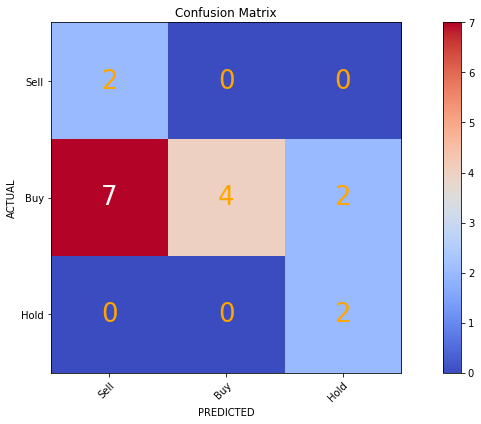

In [56]:
plot_confusion_matrix(y_test, s_pred, title="Confusion Matrix")
np.set_printoptions(precision=1)
# Plot non-normalized confusion matrix
plt.show()

### Save the optimal model we trained

In [63]:
joblib.dump(search_clf, "../save_models/adaboost_model_corr.m")

['../save_models/adaboost_model_corr.m']